# How SQLGlot shows AST?

In [ ]:
from sqlglot import parse_one
sql = """
    CREATE TABLE mart.customer_orders AS 
    SELECT 
        c.customer_name,
        c.email,
        o.order_id,
        o.order_date,
        o.amount,
        o.price,
        o.amount * o.price AS total_price
    FROM staging.orders o
    JOIN dim.customers c ON o.customer_id = c.customer_id"""
    
parse_one(sql)

# Let's iterate over columns

In [ ]:
from sqlglot import parse_one, exp
ast = parse_one(sql)
for i in ast.find_all(exp.Column):
    print(i)

# Simple Example

In [ ]:
from sqlglot import parse_one, exp
from typing import Set, Dict, List

# Example SQL queries
sql_queries = {
    "staging": """
    CREATE TABLE staging.orders AS 
    SELECT order_id, customer_id, order_date, amount, price 
    FROM raw_data.orders
    """,
    
    "mart": """
    CREATE TABLE mart.customer_orders AS 
    SELECT 
        c.customer_name,
        c.email,
        o.order_id,
        o.order_date,
        o.amount,
        o.price,
        o.amount * o.price AS total_price
    FROM staging.orders o
    JOIN dim.customers c ON o.customer_id = c.customer_id
    """
}

def get_table_lineage(sql: str) -> tuple[Set[str], Set[str]]:
    """Extract source and target tables from SQL"""
    ast = parse_one(sql)
    
    # Get target table
    target_tables = set()
    if isinstance(ast, exp.Create):
        target_tables.add(str(ast.this))
    
    # Get source tables
    source_tables = {str(t) for t in ast.find_all(exp.Table)}
    source_tables -= target_tables
    
    return source_tables, target_tables

def get_column_lineage(sql: str) -> Dict[str, List[str]]:
    """Extract column-level lineage"""
    ast = parse_one(sql)
    column_map = {}
    
    # Only handle SELECT statements in CREATE
    if isinstance(ast, exp.Create):
        select = ast.find(exp.Select)
        if select:
            for expr in select.expressions:
                target_col = expr.alias_or_name
                source_cols = [str(c) for c in expr.find_all(exp.Column)]
                column_map[target_col] = source_cols
                
    return column_map

# Demo usage
for name, sql in sql_queries.items():
    print(f"\nAnalyzing {name} query:")
    sources, targets = get_table_lineage(sql)
    print(f"Source tables: {sources}")
    print(f"Target tables: {targets}")
    
    col_lineage = get_column_lineage(sql)
    print("\nColumn lineage:")
    for target, sources in col_lineage.items():
        print(f"{target} <- {sources}")

# More Complex

In [ ]:
from sqlglot import parse_one, exp
from typing import Set, Dict, List, Tuple
from dataclasses import dataclass
from collections import defaultdict

@dataclass
class ColumnLineage:
    target_table: str
    target_column: str
    source_columns: List[Tuple[str, str]]  # (table, column)
    transformation: str = None

# More complex SQL queries
sql_queries = {
    "staging": """
    CREATE TABLE staging.enriched_orders AS 
    WITH daily_rates AS (
        SELECT date, currency, exchange_rate
        FROM raw_data.exchange_rates
        WHERE currency = 'USD'
    ),
    order_metrics AS (
        SELECT 
            o.order_id,
            o.customer_id,
            o.order_date,
            o.amount * COALESCE(r.exchange_rate, 1.0) as usd_amount,
            COUNT(*) OVER (PARTITION BY o.customer_id) as customer_order_count
        FROM raw_data.orders o
        LEFT JOIN daily_rates r ON o.order_date = r.date
    )
    SELECT 
        om.*,
        c.customer_segment,
        c.country,
        CASE 
            WHEN usd_amount > 1000 AND customer_order_count > 5 THEN 'VIP'
            WHEN usd_amount > 500 THEN 'Premium'
            ELSE 'Standard'
        END as customer_tier
    FROM order_metrics om
    JOIN dim.customers c ON om.customer_id = c.customer_id
    """,
    
    "mart": """
    CREATE TABLE mart.customer_analytics AS
    SELECT 
        c.customer_segment,
        c.country,
        DATE_TRUNC('month', o.order_date) as month,
        COUNT(DISTINCT o.customer_id) as unique_customers,
        COUNT(*) as total_orders,
        SUM(o.usd_amount) as total_revenue,
        AVG(CASE WHEN o.customer_tier = 'VIP' THEN o.usd_amount ELSE 0 END) as avg_vip_order_value
    FROM staging.enriched_orders o
    JOIN dim.customers c ON o.customer_id = c.customer_id
    GROUP BY 1, 2, 3
    HAVING COUNT(*) > 10
    """
}

def analyze_lineage(sql: str) -> Tuple[Set[str], Set[str], Dict[str, List[ColumnLineage]]]:
    """Analyze both table and column level lineage"""
    ast = parse_one(sql)
    
    # Track CTEs and their definitions
    ctes = {}
    if isinstance(ast, exp.Create):
        for cte in ast.find_all(exp.CTE):
            ctes[str(cte.alias)] = cte.this
    
    # Get target table
    target_tables = set()
    if isinstance(ast, exp.Create):
        target_tables.add(str(ast.this))
    
    # Get source tables (including CTEs)
    source_tables = {str(t) for t in ast.find_all(exp.Table)}
    source_tables -= target_tables
    
    # Column lineage analysis
    column_lineage = defaultdict(list)
    if isinstance(ast, exp.Create):
        select = ast.find(exp.Select)
        if select:
            for expr in select.expressions:
                target_col = expr.alias_or_name
                
                # Get source columns
                source_cols = []
                for col in expr.find_all(exp.Column):
                    table = str(col.table) if col.table else None
                    source_cols.append((table, str(col.name)))
                
                # Get transformation info
                transform = None
                # if isinstance(expr, exp.Function):
                #    transform = f"Function: {expr.key}"
                #el
                if isinstance(expr, exp.Case):
                    transform = "CASE statement"
                #elif isinstance(expr, exp.Operation):
                #    transform = f"Operation: {expr.key}"
                
                lineage = ColumnLineage(
                    target_table=str(ast.this),
                    target_column=target_col,
                    source_columns=source_cols,
                    transformation=transform
                )
                column_lineage[str(ast.this)].append(lineage)
    
    return source_tables, target_tables, dict(column_lineage)

# Demo usage
for name, sql in sql_queries.items():
    print(f"\nAnalyzing {name} query:")
    sources, targets, col_lineage = analyze_lineage(sql)
    
    print(f"Source tables: {sources}")
    print(f"Target tables: {targets}")
    
    print("\nColumn lineage:")
    for table, columns in col_lineage.items():
        print(f"\nTable: {table}")
        for col in columns:
            print(f"\nTarget column: {col.target_column}")
            print(f"Source columns: {col.source_columns}")
            if col.transformation:
                print(f"Transformation: {col.transformation}")

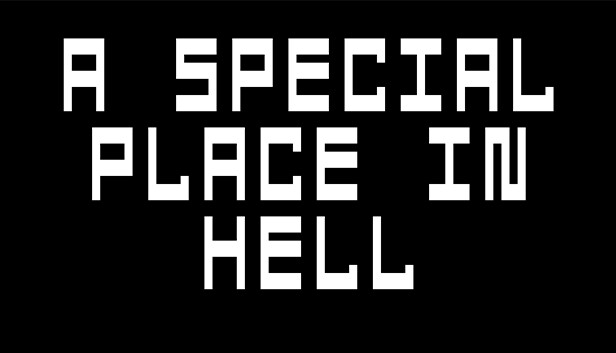

In [ ]:
from sqlglot import parse_one, exp
from typing import Set, Dict, List, Tuple
from dataclasses import dataclass
from collections import defaultdict
from sqlglot.optimizer.qualify import qualify

@dataclass
class ColumnLineage:
    target_table: str
    target_column: str
    source_columns: List[Tuple[str, str]]  # (table, column)
    transformation: str = None

# More complex SQL queries
sql_queries = {
    "staging": """
    CREATE TABLE staging.enriched_orders AS 
    WITH daily_rates AS (
        SELECT date, currency, exchange_rate
        FROM raw_data.exchange_rates
        WHERE currency = 'USD'
    ),
    order_metrics AS (
        SELECT 
            o.order_id,
            o.customer_id,
            o.order_date,
            o.amount * COALESCE(r.exchange_rate, 1.0) as usd_amount,
            COUNT(*) OVER (PARTITION BY o.customer_id) as customer_order_count
        FROM raw_data.orders o
        LEFT JOIN daily_rates r ON o.order_date = r.date
    )
    SELECT 
        om.*,
        c.customer_segment,
        c.country,
        CASE 
            WHEN usd_amount > 1000 AND customer_order_count > 5 THEN 'VIP'
            WHEN usd_amount > 500 THEN 'Premium'
            ELSE 'Standard'
        END as customer_tier
    FROM order_metrics om
    JOIN dim.customers c ON om.customer_id = c.customer_id
    """,
    
    "mart": """
    CREATE TABLE mart.customer_analytics AS
    SELECT 
        c.customer_segment,
        c.country,
        DATE_TRUNC('month', o.order_date) as month,
        COUNT(DISTINCT o.customer_id) as unique_customers,
        COUNT(*) as total_orders,
        SUM(o.usd_amount) as total_revenue,
        AVG(CASE WHEN o.customer_tier = 'VIP' THEN o.usd_amount ELSE 0 END) as avg_vip_order_value
    FROM staging.enriched_orders o
    JOIN dim.customers c ON o.customer_id = c.customer_id
    GROUP BY 1, 2, 3
    HAVING COUNT(*) > 10
    """
}

def analyze_lineage(sql: str) -> Tuple[Set[str], Set[str], Dict[str, List[ColumnLineage]]]:
    """Analyze both table and column level lineage"""
    ast = qualify(parse_one(sql), expand_stars=True)
    
    # Track CTEs and their definitions
    ctes = {}
    if isinstance(ast, exp.Create):
        for cte in ast.find_all(exp.CTE):
            ctes[str(cte.alias)] = cte.this
    
    # Get target table
    target_tables = set()
    if isinstance(ast, exp.Create):
        target_tables.add(str(ast.this))
    
    # Get source tables (including CTEs)
    source_tables = {str(t) for t in ast.find_all(exp.Table)}
    source_tables -= target_tables
    
    # Column lineage analysis
    column_lineage = defaultdict(list)
    if isinstance(ast, exp.Create):
        select = ast.find(exp.Select)
        if select:
            for expr in select.expressions:
                target_col = expr.alias_or_name
                
                # Get source columns
                source_cols = []
                for col in expr.find_all(exp.Column):
                    table = str(col.table) if col.table else None
                    source_cols.append((table, str(col.name)))
                
                # Get transformation info
                transform = None
                # if isinstance(expr, exp.Function):
                #    transform = f"Function: {expr.key}"
                #el
                if isinstance(expr, exp.Case):
                    transform = "CASE statement"
                #elif isinstance(expr, exp.Operation):
                #    transform = f"Operation: {expr.key}"
                
                lineage = ColumnLineage(
                    target_table=str(ast.this),
                    target_column=target_col,
                    source_columns=source_cols,
                    transformation=transform
                )
                column_lineage[str(ast.this)].append(lineage)
    
    return source_tables, target_tables, dict(column_lineage)

# Demo usage
for name, sql in sql_queries.items():
    print(f"\nAnalyzing {name} query:")
    sources, targets, col_lineage = analyze_lineage(sql)
    
    print(f"Source tables: {sources}")
    print(f"Target tables: {targets}")
    
    print("\nColumn lineage:")
    for table, columns in col_lineage.items():
        print(f"\nTable: {table}")
        for col in columns:
            print(f"\nTarget column: {col.target_column}")
            print(f"Source columns: {col.source_columns}")
            if col.transformation:
                print(f"Transformation: {col.transformation}")

# Can I pass schema to handle "select *"?

In [ ]:
sql = "SELECT orders.* FROM orders JOIN customers ON orders.customer_id = customers.id"
print(parse_one(sql).sql(pretty=True))

In [ ]:


schema = {"orders": {"id": "INT", "order_date": "DATE", "amount": "FLOAT", "price": "FLOAT", "customer_id": "int"}, "customers": {"id": "INT", "name": "varchar", "email": "varchar"}, "exchange_rates": {"date": "DATE", "currency": "STRING", "exchange_rate": "FLOAT"}}
expression = parse_one(sql)
ast = qualify(expression, schema=schema, expand_stars=True).sql(pretty=True)
print(ast)